## EigenGAN for YOLOv5 (Object detection)

In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-7ni3j7e9
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-7ni3j7e9
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install torchcam


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
import requests
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import scipy.io

In [4]:
# Create random colors for 80 classes
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results, confidence_threshold=0.2):
    detections = results.pandas().xyxy[0]

    boxes, colors, names = [], [], []

    for _, det in detections.iterrows():
        if det['confidence'] < confidence_threshold:
            continue

        box = (int(det['xmin']), int(det['ymin']), int(det['xmax']), int(det['ymax']))
        color = COLORS[int(det['class'])]
        name = det['name']

        boxes.append(box)
        colors.append(color)
        names.append(name)

    return boxes, colors, names

def draw_detections(img, boxes, colors, names, thickness=2, font_scale=0.8):
    img_copy = img.copy()

    for (box, color, name) in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box

        # Draw rectangle
        cv2.rectangle(img_copy, (xmin, ymin), (xmax, ymax), color, thickness)

        # Put label
        label_position = (xmin, max(ymin - 10, 0))  # Avoid going out of image
        cv2.putText(img_copy, name, label_position,
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, lineType=cv2.LINE_AA)

    return img_copy


In [5]:
# Load the image
image = "/content/16.jpg"
img = cv2.imread(image)  # Read the image from the path

# Resize the image
img = cv2.resize(img, (576, 1024))

# Convert to RGB (OpenCV uses BGR by default)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Normalize the image and convert to tensor
img = np.float32(img) / 255  # Normalize the image to [0, 1]
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()

target_layers = [model.model.model.model[-8]]


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-4-30 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 131MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [7]:
output = model([rgb_img])
b, c, n = parse_detections(output)
dets = draw_detections(rgb_img, b, c, n)

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


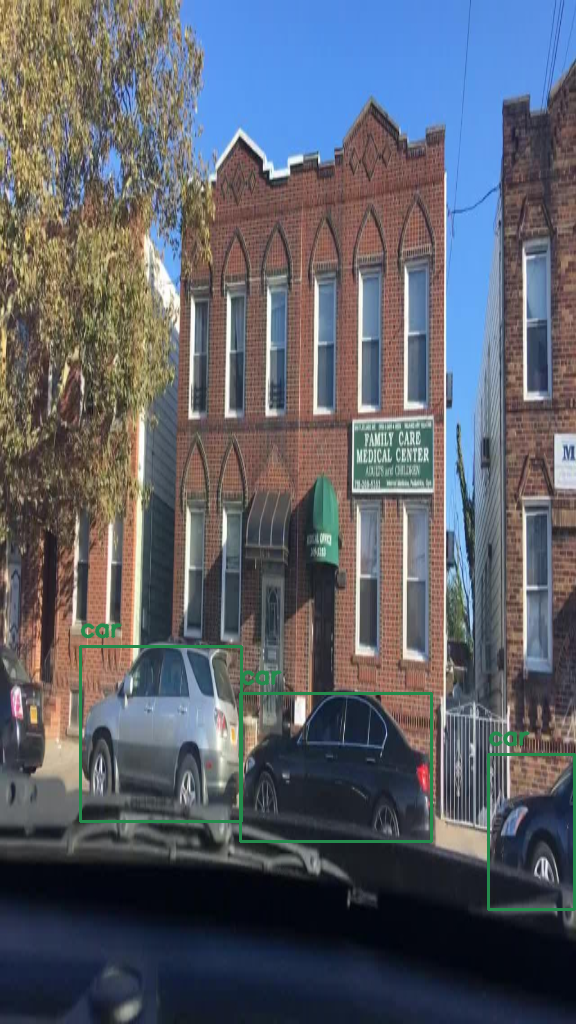

In [8]:
Image.fromarray(dets)

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


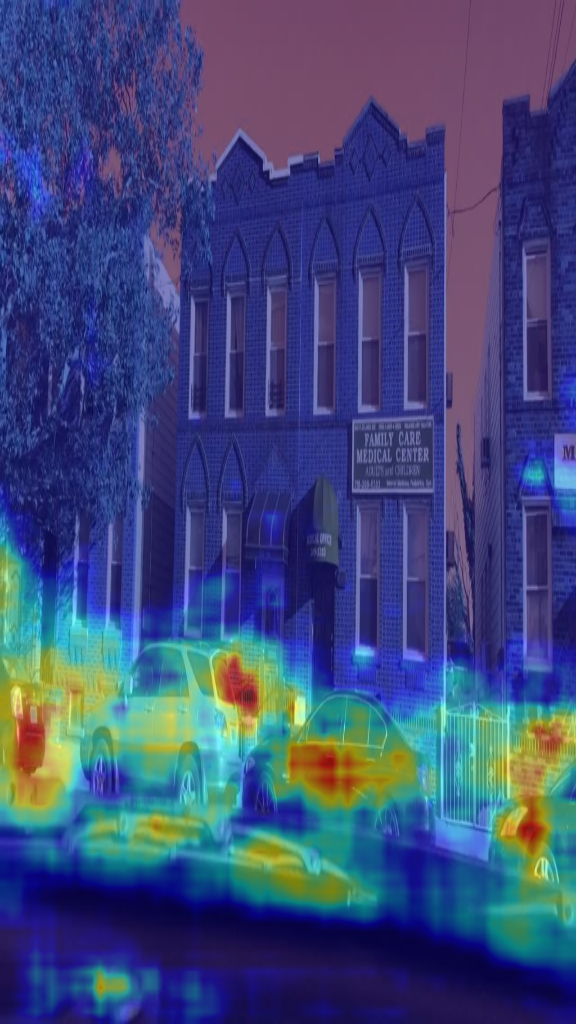

In [9]:
cam_output = EigenCAM(model, target_layers)
grayscale_cam = cam_output(tensor)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img, grayscale_cam,use_rgb=True)
Image.fromarray(visualization)

In [10]:
grayscale_cam

array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [   0.021855,    0.021855,    0.021855, ...,    0.065838,    0.065838,    0.065838],
       [   0.021855,    0.021855,    0.021855, ...,    0.065838,    0.065838,    0.065838],
       [   0.021855,    0.021855,    0.021855, ...,    0.065838,    0.065838,    0.065838]], dtype=float32)

In [11]:
def compute_pcc(saliency_flat, human_attention_flat):
    pcc, _ = pearsonr(saliency_flat, human_attention_flat)
    return pcc

def compute_rmse(saliency_flat, human_attention_flat):
    rmse = np.sqrt(mean_squared_error(saliency_flat, human_attention_flat))
    return rmse

def compute_srocc(saliency_flat, human_attention_flat):
    srocc, _ = spearmanr(saliency_flat, human_attention_flat)
    return srocc

attn_path = '/content/16_GSmo_30.mat'

mat_data = scipy.io.loadmat(attn_path)
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Aug 31 21:27:28 2022',
 '__version__': '1.0',
 '__globals__': [],
 'output_map_norm': array([[ 2.6494e-09,  2.4108e-09,  2.1902e-09, ...,  3.4838e-09,  3.1848e-09,   2.907e-09],
        [ 2.0423e-09,  1.8582e-09,   1.688e-09, ...,  2.6865e-09,  2.4556e-09,  2.2412e-09],
        [  1.571e-09,  1.4292e-09,  1.2982e-09, ...,  2.0673e-09,  1.8894e-09,  1.7242e-09],
        ...,
        [ 5.7103e-09,  5.1978e-09,  4.7238e-09, ...,  7.5008e-09,  6.8595e-09,  6.2634e-09],
        [ 4.4301e-09,   4.032e-09,  3.6639e-09, ...,  5.8212e-09,  5.3229e-09,  4.8598e-09],
        [ 3.4296e-09,  3.1211e-09,  2.8358e-09, ...,  4.5081e-09,  4.1217e-09,  3.7627e-09]])}

In [12]:
human_attention_map = mat_data['output_map_norm']
human_attention_map = np.array(human_attention_map)
human_attention_map = human_attention_map.flatten()
grayscale_cam = grayscale_cam.flatten()

pcc = compute_pcc(grayscale_cam, human_attention_map)
rmse = compute_rmse(grayscale_cam, human_attention_map)
srocc = compute_srocc(grayscale_cam, human_attention_map)

print(f"PCC: {pcc}")
print(f"RMSE: {rmse}")
print(f"SROCC: {srocc}")

PCC: 0.48198764449908266
RMSE: 0.18644159150883763
SROCC: 0.595199576793401


In [16]:
import torch
import torch.nn.functional as F

def model_fn(img_np):
    import torchvision.transforms as T
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float()

    # No normalization needed for YOLOv5 — it's trained on [0,1] scaled images
    img_tensor = img_tensor
    with torch.no_grad():
        results = model(img_tensor)[0]  # this gives predictions
        if results.shape[0] == 0:
            return 0.0  # No detection
        else:
            # Objectness * class probability = confidence
            best_conf = results[:, 4] * results[:, 5:].max(dim=1)[0]
            return best_conf.max().item()



/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [17]:
import numpy as np
from skimage.transform import resize

def insertion_score(image, saliency_map, model_fn, steps=100):
    image = image.copy()
    h, w = image.shape[0:2]
    sal_order = np.argsort(-saliency_map)  # Most salient first

    baseline = np.zeros_like(image)
    scores = []

    for i in range(1, steps + 1):
        mask = np.zeros(h * w)
        mask[sal_order[:int(i * h * w / steps)]] = 1
        mask = mask.reshape(h, w)
        mask = np.stack([mask]*3, axis=2)
        inserted_image = baseline * (1 - mask) + image * mask
        scores.append(model_fn(inserted_image))

    return np.mean(scores)

def deletion_score(image, saliency_map, model_fn, steps=100):
    image = image.copy()
    h, w = image.shape[0:2]
    sal_order = np.argsort(-saliency_map)

    scores = []

    for i in range(1, steps + 1):
        mask = np.ones(h * w)
        mask[sal_order[:int(i * h * w / steps)]] = 0
        mask = mask.reshape(h, w)
        mask = np.stack([mask]*3, axis=2)
        deleted_image = image * mask
        scores.append(model_fn(deleted_image))

    return np.mean(scores)


In [19]:
insw = insertion_score(img, grayscale_cam, model_fn)
delw = deletion_score(img, grayscale_cam, model_fn)
print(f"Insertion Score: {insw}")
print(f"Deletion Score: {delw}")

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.am

Insertion Score: 0.659085047096014
Deletion Score: 0.26119450356593005
